# BN层在ReLU激活层之前

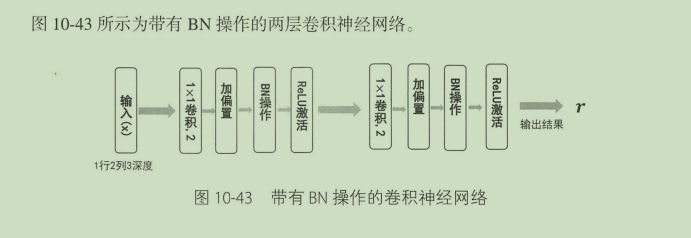

In [10]:
import tensorflow as tf
import numpy as np

#---------------读取数据----------------
# 创建TFRecordReader对象
epochs=2
reader = tf.TFRecordReader()
records_queue = tf.train.string_input_producer(['dataTest.tfrecord'], num_epochs=epochs)
_,serialized_example = reader.read(records_queue)
# 解析文件中的图像及其对应的标签
features = tf.parse_single_example(
serialized_example,
features={
    'array_raw':tf.FixedLenFeature([], tf.string)
})

# 解码二进制
array_raw = features['array_raw']
array_raw = tf.decode_raw(array_raw, tf.float32)
array = tf.reshape(array_raw , [1,2,3])
# 每次从文件中读取2个数据
BatchSize = 2 # 不能大于文件中的数据的个数
arrays = tf.train.shuffle_batch([array], BatchSize , 1000+3*BatchSize , 1000)




#输入值的占位符
x=tf.placeholder(tf.float32, [None, 1,2,3])
#设置是否为训练阶段的占位符
trainable=tf.placeholder(tf.bool)
#移动平均
ema=tf.train.ExponentialMovingAverage(0.7)
ema_var_list=[]
#-------------第1层-------------
# 2个1行1列3深度的卷积核
k1=tf.Variable(tf.constant([
    [[[1,0] ,[0,1], [0,0]]]
],tf.float32))

#偏置
b1=tf.Variable(tf.zeros(2))
#卷积结果加偏置
c1=tf.nn.conv2d(x, k1,[1,1,1,1],'SAME') + b1
beta1=tf.Variable(tf.zeros(c1.get_shape()[-1].value))
gamma1=tf.Variable(tf.ones(c1.get_shape()[-1].value))
#计算每一个深度上的均值和方差
m1, v1=tf.nn.moments(c1, [0,1,2])
ema_var_list+=[m1,v1]
#为了保存均值和方差的指数移动平均
m1_ema=tf.Variable(tf.zeros(c1.get_shape()[-1]) ,trainable=False)
v1_ema=tf.Variable(tf.zeros(c1.get_shape()[-1]) ,trainable=False)

#BN操作
c1_BN=tf.cond(trainable, 
             lambda: tf.nn.batch_normalization(c1, m1, v1, beta1, gamma1, 1e-8),
             lambda: tf.nn.batch_normalization(c1, m1_ema, v1_ema, beta1, gamma1, 1e-8)
            )

#relu激活函数
r1=tf.nn.relu(c1_BN)

#---------------第2层-------------------
# 2个1行1列2深度的卷积核
k2=tf.Variable(tf.constant([
    [[[2,0] ,[0,2]]]
],tf.float32))

#偏置
b2=tf.Variable(tf.zeros(2))
#卷积结果加偏置
c2=tf.nn.conv2d(r1, k2,[1,1,1,1],'SAME') + b2
beta2=tf.Variable(tf.zeros(c2.get_shape()[-1].value))
gamma2=tf.Variable(tf.ones(c2.get_shape()[-1].value))
#计算每一个深度上的均值和方差
m2, v2=tf.nn.moments(c2, [0,1,2])
ema_var_list+=[m2,v2]
#为了保存均值和方差的指数移动平均
m2_ema=tf.Variable(tf.zeros(c1.get_shape()[-1]) ,trainable=False)
v2_ema=tf.Variable(tf.zeros(c1.get_shape()[-1]) ,trainable=False)

#BN操作
c2_BN=tf.cond(trainable, 
             lambda: tf.nn.batch_normalization(c2, m2, v2, beta2, gamma2, 1e-8),
             lambda: tf.nn.batch_normalization(c2, m2_ema, v2_ema, beta2, gamma2, 1e-8)
            )

#relu激活函数
r2=tf.nn.relu(c2_BN)

update_moving_avg=ema.apply(ema_var_list)

#创建会话
session=tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=session , coord=coord)
num=2
for i in range(num):
    arrs=session.run(arrays)
    print('---第%(num)d批array----'%{'num':i+1})
    print(arrs)
    
    _,c1_arr=session.run([update_moving_avg, c1], feed_dict={x:arrs, trainable:True})
    
    print('---第%(num)d次迭代后， 第1个卷积层（卷积结果加偏置）的值---'%{'num':i+1})
    
    print(c1_arr)
    
    # 将计算的指数移动平均分的值赋值给Variable对象
    session.run(m1_ema.assign(ema.average(m1)))
    session.run(v1_ema.assign(ema.average(v1)))
    session.run(m2_ema.assign(ema.average(m2)))
    session.run(v2_ema.assign(ema.average(v2)))
    
    print('---第%(num)d次迭代后， 第1个卷积层的均值的移动平均值---'%{'num':i+1})
    
    print(session.run(m1_ema))
    
coord.request_stop()
coord.join(threads)
session.close()

---第1批array----
[[[[1. 2. 3.]
   [4. 5. 6.]]]


 [[[1. 2. 3.]
   [4. 5. 6.]]]]
---第1次迭代后， 第1个卷积层（卷积结果加偏置）的值---
[[[[1. 2.]
   [4. 5.]]]


 [[[1. 2.]
   [4. 5.]]]]
---第1次迭代后， 第1个卷积层的均值的移动平均值---
[0.75      1.0500001]
---第2批array----
[[[[11. 12. 13.]
   [14. 15. 16.]]]


 [[[21. 22. 23.]
   [24. 25. 26.]]]]
---第2次迭代后， 第1个卷积层（卷积结果加偏置）的值---
[[[[11. 12.]
   [14. 15.]]]


 [[[21. 22.]
   [24. 25.]]]]
---第2次迭代后， 第1个卷积层的均值的移动平均值---
[5.775    6.285001]


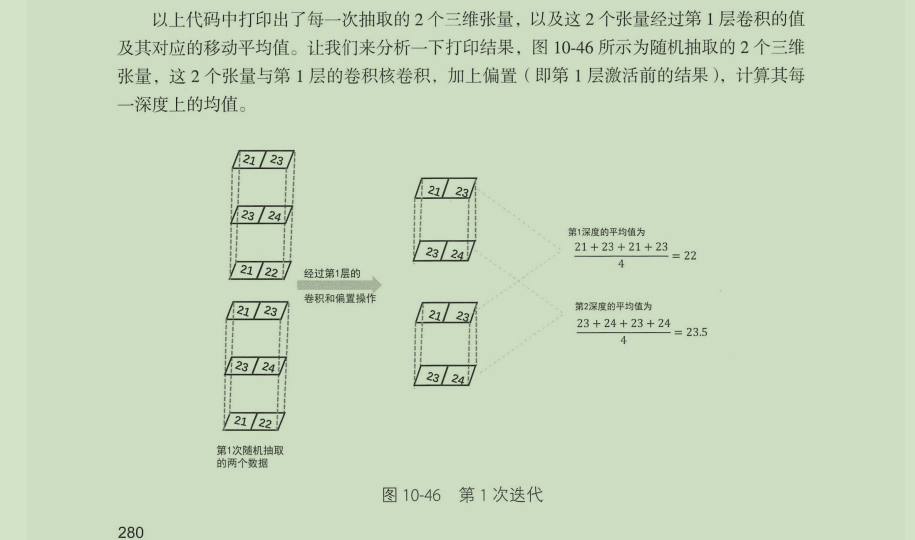

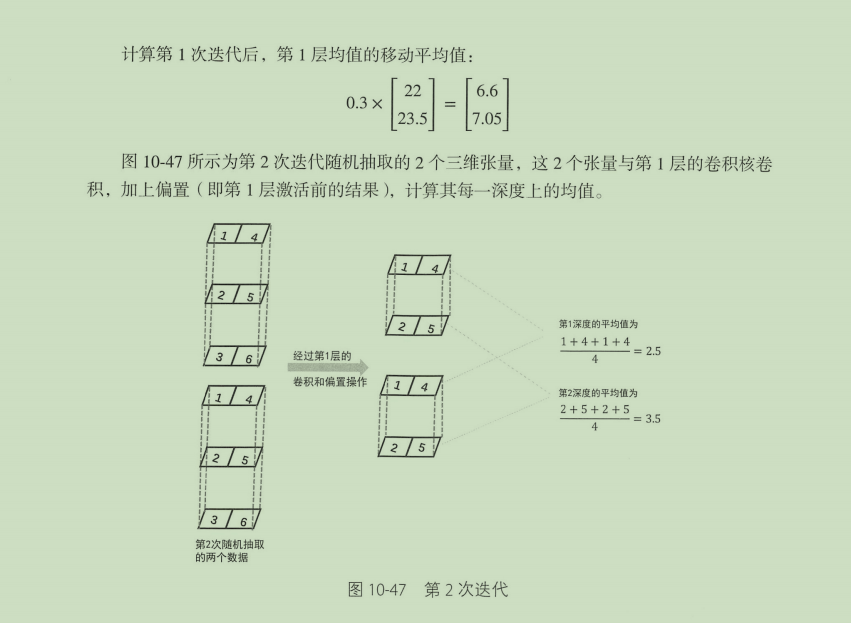

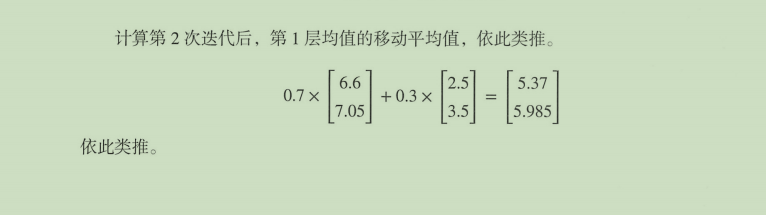